# Exercise 1 Implementation

Training

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import time
from memory_profiler import memory_usage
from sklearn.metrics import confusion_matrix
import os
import gc
import psutil

[[191 185 174 ...  19  17   1]
 [ 66  72  67 ... 166 163   1]
 [106 103 103 ...  36  41   1]
 ...
 [183 250 163 ...  95 106  52]
 [ 77  72  68 ... 103 110  52]
 [ 27  29  30 ... 127 181  52]] (416, 2577)
[[161 162 160 ...  47  46   1]
 [ 93  95  81 ... 100  91   1]
 [130 133 124 ...  60  47   2]
 ...
 [ 96  98  88 ...  40  41  51]
 [ 86  63  51 ... 107 120  52]
 [ 60  68  71 ...  48  65  52]] (104, 2577)


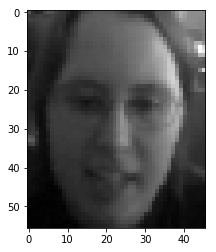

In [2]:
# Load the training and testing sets: 80% is training, 20% is testing

splittype = 'class'

if (splittype == 'whole'):
    training = np.loadtxt('split_whole_train.gzip', dtype = 'uint8')
    test = np.loadtxt('split_whole_test.gzip', dtype = 'uint8')
elif (splittype == 'class'):
    training = np.loadtxt('split_class_train.gzip', dtype = 'uint8')
    test = np.loadtxt('split_class_test.gzip', dtype = 'uint8')
    
print (training, training.shape)
print (test, test.shape)

plt.imshow(np.reshape(training[100, :2576], (46,56)).T, cmap = 'gist_gray') 
# Print 100th image of the training set as a sanity check to make sure we have shuffled along the right dimension of the array

(Text(0.5,1,'Mean image of the training set'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

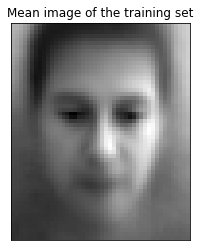

In [3]:
# Now let's start training our image recognition PCA algorithm
# We have face images that are CENTERED and they are of the SAME SIZE (needed for PCA)
# They are normalised for SCALE, ORIENTATION and TRANSLATION

# First, we only need the training and testing set without the labels
# Images are represented as rows
pca_train = training [:, :2576]
pca_test = test [:, :2576]

# Let's compute the mean face image
avg_face = np.mean(pca_train, axis=0)
plt.imshow(np.reshape(avg_face, (46,56)).T, cmap = 'gist_gray')
plt.title('Mean image of the training set'), plt.xticks([]), plt.yticks([])


[[2623.27514793 2492.31767751 2315.7039571  ... -603.43407914
  -627.42326183 -597.15745192]
 [2492.31767751 2754.63644138 2639.25177977 ... -582.70764377
  -628.06536612 -606.77448918]
 [2315.7039571  2639.25177977 2788.60038369 ... -574.91074565
  -616.98030695 -599.2116887 ]
 ...
 [-603.43407914 -582.70764377 -574.91074565 ... 2918.61343727
  2801.54109652 2679.11921575]
 [-627.42326183 -628.06536612 -616.98030695 ... 2801.54109652
  3049.01886095 2934.29146635]
 [-597.15745192 -606.77448918 -599.2116887  ... 2679.11921575
  2934.29146635 3049.6246244 ]] (2576, 2576)


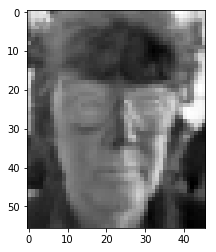

In [4]:
# Now let's subtract the mean face image from all of our training face images
pca_train_norm = pca_train-avg_face # works because of broadcasting
plt.imshow(np.reshape(pca_train_norm[0, :], (46,56)).T, cmap = 'gist_gray') 
# Show the first normalised face image and notice that it is distorted

# Computing the covariance matrix
cov = (np.dot(pca_train_norm.T, pca_train_norm))/416
print (cov, cov.shape)

In [5]:
# Computing the eigenvalues and eigenvectors of the covariance matrix directly and measuring how long it takes

start = time.time()
eigvals, eigvecs = np.linalg.eig(cov) # these are not ordered, so we need to order them according to the eigenvalues
end = time.time()
print (end-start) # Execution time in seconds

print (eigvals, eigvals.shape)
print (eigvecs, eigvecs.shape)
print (eigvals.min()) # Note that the smallest eigenvalue (most negative) is a zero eigenvalue (rounding error)

6.943857908248901
[ 9.40265187e+05+0.00000000e+00j  5.48902335e+05+0.00000000e+00j
  4.24998965e+05+0.00000000e+00j ... -2.15577147e-14+6.14199796e-14j
 -2.15577147e-14-6.14199796e-14j  1.55840518e-14+0.00000000e+00j] (2576,)
[[-1.38720339e-02+0.j          1.54692475e-02+0.j
   1.91130355e-02+0.j         ... -9.84015585e-04+0.0010764j
  -9.84015585e-04-0.0010764j  -1.81543153e-03+0.j        ]
 [-1.50286352e-02+0.j          1.49678440e-02+0.j
   1.95760572e-02+0.j         ... -7.02515098e-04-0.00012444j
  -7.02515098e-04+0.00012444j -6.99592750e-04+0.j        ]
 [-1.58879342e-02+0.j          1.37695539e-02+0.j
   2.04652323e-02+0.j         ... -9.68326863e-05+0.0004069j
  -9.68326863e-05-0.0004069j  -1.67812343e-03+0.j        ]
 ...
 [ 3.54993963e-03+0.j         -5.16500787e-02+0.j
  -1.32464995e-03+0.j         ...  6.12275058e-03-0.01072289j
   6.12275058e-03+0.01072289j -1.51794797e-02+0.j        ]
 [ 3.15728786e-03+0.j         -5.11799075e-02+0.j
  -1.27773186e-03+0.j         ... -8.

In [6]:
# Proving that the eigenvalues and eigenvectors make sense

eig_test_1 = np.dot(cov, eigvecs[:, 0])
eig_test_2 = eigvecs[:, 0]*eigvals[0]

print (eig_test_1-eig_test_2, (eig_test_1-eig_test_2).shape) # The values are basically zero, so the eigenvalue computation is correct

[-3.63797881e-11+0.j  1.81898940e-10+0.j -3.27418093e-11+0.j ...
  4.54747351e-13+0.j  4.09272616e-12+0.j -1.00044417e-11+0.j] (2576,)


In [7]:
# Taking the real part of the eigenvalues (complex eigenvalues are the result of calculation rounding errors, because the covariance matrix is symmetric)

eigvals = np.real(eigvals)
print (eigvals, eigvals.shape)
eigvecs = np.real(eigvecs)
print (eigvecs, eigvecs.shape)

[ 9.40265187e+05  5.48902335e+05  4.24998965e+05 ... -2.15577147e-14
 -2.15577147e-14  1.55840518e-14] (2576,)
[[-1.38720339e-02  1.54692475e-02  1.91130355e-02 ... -9.84015585e-04
  -9.84015585e-04 -1.81543153e-03]
 [-1.50286352e-02  1.49678440e-02  1.95760572e-02 ... -7.02515098e-04
  -7.02515098e-04 -6.99592750e-04]
 [-1.58879342e-02  1.37695539e-02  2.04652323e-02 ... -9.68326863e-05
  -9.68326863e-05 -1.67812343e-03]
 ...
 [ 3.54993963e-03 -5.16500787e-02 -1.32464995e-03 ...  6.12275058e-03
   6.12275058e-03 -1.51794797e-02]
 [ 3.15728786e-03 -5.11799075e-02 -1.27773186e-03 ... -8.76384296e-04
  -8.76384296e-04  9.37537163e-03]
 [ 3.18517278e-03 -5.16501917e-02 -3.22409734e-03 ...  8.63612523e-03
   8.63612523e-03  2.35392030e-02]] (2576, 2576)


[   0    1    2 ... 2575 2072 2071] (2576,)
[9.40265187e+05 5.48902335e+05 4.24998965e+05 ... 1.55840518e-14
 1.30227368e-14 1.30227368e-14] (2576,)
415
0
415
940265.1866646743
86.15217069995816
3.83262199540484e-11
Eigenfaces example:


(Text(0.5,1,'Third Eigenface'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

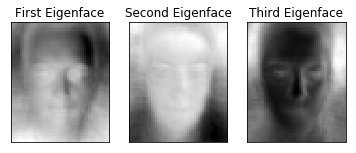

In [8]:
# Order eigenvalues and eigenvectors according to the size of the eigenvalues

index = (abs(eigvals)).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector eigvals)
eigvals = eigvals[index]
eigvecs = eigvecs[:,index]
print (index, index.shape)
print (eigvals, eigvals.shape)

# How many zero eigenvalues do we have?

print (np.linalg.matrix_rank(cov)) # We should have 2576 - 415 = 2161 zero eigenvalues
print ((eigvals == np.zeros(eigvals.shape)).sum()) # The rounding errors will give 0 eigenvalues that are precisely zero
print ((abs(eigvals) >= np.ones(eigvals.shape)/100000).sum()) # However there are 415 eigenvalues that are larger than 1e-05, which can be considered zero eigenvectors.
print (eigvals.max()) # The largest eigenvalue
print (eigvals[414])
print (eigvals[415]) # Zero eigenvalue

# Showing the top 3 eigenfaces

print("Eigenfaces example:")
plt.subplot(131),plt.imshow(np.reshape(eigvecs[:, 0].T, (46,56)).T, cmap = 'gist_gray')
plt.title('First Eigenface'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(np.reshape(eigvecs[:, 1].T, (46,56)).T, cmap = 'gist_gray')
plt.title('Second Eigenface'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(np.reshape(eigvecs[:, 2].T, (46,56)).T, cmap = 'gist_gray')
plt.title('Third Eigenface'), plt.xticks([]), plt.yticks([])

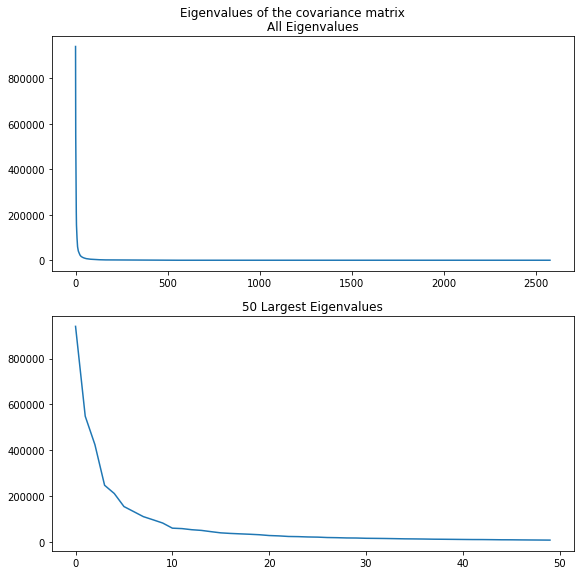

In [9]:
# Let's visualise the eigenvalues

x = np.arange(0, 2576)
fig, axs = plt.subplots(2, 1, constrained_layout = True, figsize = (8, 8))
axs[0].plot(x, eigvals, '-')
axs[0].set_title('All Eigenvalues')
#axs[0].set_ylabel('Eigenvalues')
fig.suptitle('Eigenvalues of the covariance matrix')
axs[1].plot(x[:50], eigvals[:50], '-')
axs[1].set_title('50 Largest Eigenvalues')
#axs[1].set_ylabel('Eigenvalues')
plt.show()

In [10]:
# We keep the largest n eigenvalues and their corresponding eigenvectors n<=415, the other eigenvalues are zero

n = 50
eigvecs_best = eigvecs[:, :n]
eigvals_best = eigvals[:n]

# Projecting each training data point to the space spanned by the eigenvectors
proj_pca_train_norm = np.zeros((416, n))
for i in range(416):
    proj_pca_train_norm [i, :] = np.dot(pca_train_norm[i, :], eigvecs_best)
    
print (proj_pca_train_norm, proj_pca_train_norm.shape)

# Now in array proj_pca_train_norm, in each row, we have the projected coordinates for each face image

[[-1.70647565e+02  7.06366822e+02  4.76647660e+02 ... -1.10016583e+02
   1.18726862e+02  1.57964262e+01]
 [ 1.61369069e+03 -1.13199247e+03  3.69998990e+01 ...  1.47023298e+01
  -1.66776786e+02 -2.68931057e+01]
 [-6.38500154e+02  3.53806504e+02 -3.52791598e+02 ... -2.13264355e+02
   1.62096997e+02 -7.69812587e+01]
 ...
 [-1.01994005e+00 -2.08258313e+02  2.21537224e+01 ... -4.91326535e+01
   8.65177735e+01  2.22651702e+01]
 [ 4.16842811e+02 -2.41495672e+02 -5.89248471e+02 ...  1.27977025e+01
  -6.28293652e+01 -1.42372815e+02]
 [-3.48235021e+02 -3.50946042e+02 -6.75276535e+02 ...  1.82058872e+02
   2.40877584e+01 -2.92250948e+01]] (416, 50)


In [11]:
# Let's try to compute the eigenvalues using the low-dimensional method

# First we need to compute the new covariance matrix (1/N)A^T*A
cov_ld = np.dot(pca_train_norm, pca_train_norm.T)/416
print (cov_ld, cov_ld.shape) # as we can see it is NxN (and not DxD as the covariance matrix we had before)

[[ 8400.41242727 -2416.46651942  5337.74777537 ...   -45.26635878
  -1861.53235361 -1967.30578533]
 [-2416.46651942 13668.58241849 -3309.64319056 ...   294.93402144
   1879.0574497   -924.26405895]
 [ 5337.74777537 -3309.64319056 12005.12398885 ...  -512.97427992
   -545.34844782 -1237.38630262]
 ...
 [  -45.26635878   294.93402144  -512.97427992 ...  8865.83610516
   3046.93549495  2308.81590938]
 [-1861.53235361  1879.0574497   -545.34844782 ...  3046.93549495
   6071.65988474  3368.85520302]
 [-1967.30578533  -924.26405895 -1237.38630262 ...  2308.81590938
   3368.85520302 11485.99523284]] (416, 416)


In [12]:
# Now we compute the eigenvalues and eigenvectors of the new covariance matrix and measure the elapsed time

start_ld = time.time()
eigvals_ld, eigvecs_ld = np.linalg.eig(cov_ld) # these are not ordered, so we order them and the corresponding eigenvalues
end_ld = time.time()
print (end_ld-start_ld)
print (end-start)

# Taking the real part of the eigenvalues (complex eigenvalues are the result of calculation rounding errors, because the covariance matrix is symmetric)

eigvals_ld = np.real(eigvals_ld)
eigvecs_ld = np.real(eigvecs_ld)

# Order eigenvalues and eigenvectors according to the size of the eigenvalues

index_ld = abs(eigvals_ld).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector eigvals)
eigvals_ld = eigvals_ld[index_ld]
eigvecs_ld = eigvecs_ld[:,index_ld]
print (eigvals_ld, eigvals_ld.shape)

0.054061174392700195
6.943857908248901
[9.40265187e+05 5.48902335e+05 4.24998965e+05 2.47947880e+05
 2.12116486e+05 1.55276206e+05 1.33388986e+05 1.11403489e+05
 9.76145141e+04 8.34728360e+04 6.11198228e+04 5.92174870e+04
 5.43751165e+04 5.13718047e+04 4.58404616e+04 4.06801594e+04
 3.81821472e+04 3.63461106e+04 3.45735249e+04 3.24526319e+04
 2.90044532e+04 2.74593000e+04 2.49056436e+04 2.42470308e+04
 2.27889764e+04 2.20832792e+04 2.03329353e+04 1.96510256e+04
 1.85064452e+04 1.81807023e+04 1.70040335e+04 1.66020625e+04
 1.61024823e+04 1.54065960e+04 1.46255545e+04 1.42448055e+04
 1.37343073e+04 1.30387610e+04 1.27566242e+04 1.23520067e+04
 1.18998952e+04 1.15341726e+04 1.14196749e+04 1.10157484e+04
 1.05176699e+04 1.03955916e+04 9.98814220e+03 9.66202398e+03
 9.39098435e+03 9.06425626e+03 8.85681122e+03 8.54592175e+03
 8.34702725e+03 8.22795136e+03 7.92242391e+03 7.75860791e+03
 7.44997277e+03 7.14221841e+03 7.05066722e+03 6.91750498e+03
 6.81320783e+03 6.65711699e+03 6.59652587e+03 

415
0
415
940265.1866646782
86.15217069995616
1.8028203213128043e-11


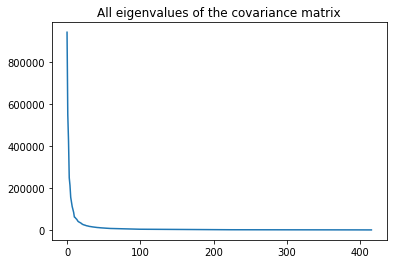

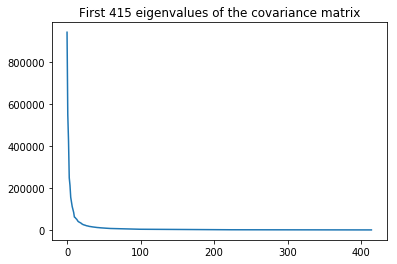

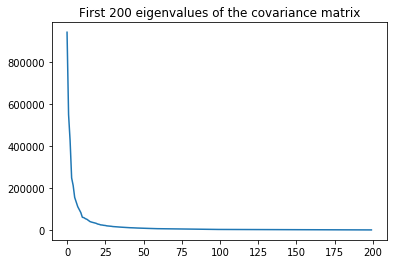

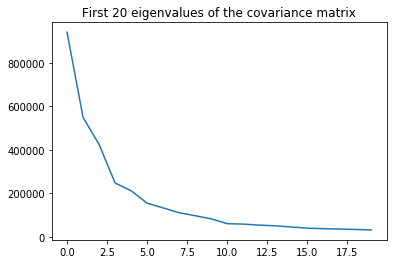

<Figure size 432x288 with 0 Axes>

In [13]:
# How many zero eigenvalues do we have this time?

print (np.linalg.matrix_rank(cov_ld)) # We should have 2576 - 415 = 2161 zero eigenvalues
print ((eigvals_ld == np.zeros(eigvals_ld.shape)).sum()) # The rounding errors will give 0 eigenvalues that are precisely zero
print ((abs(eigvals_ld) >= np.ones(eigvals_ld.shape)/100000).sum()) # However there are 415 eigenvalues that are larger than 1e-05, which can be considered zero eigenvectors.
print (eigvals_ld.max()) # The largest eigenvalue
print (eigvals_ld[414])
print (eigvals_ld[415])

# Let's visualise the eigenvalues

x = np.arange(0, 416)

# All of them
plt.plot(x, eigvals_ld) # Clearly out of scale
plt.title('All eigenvalues of the covariance matrix')
plt.figure()

# First 415 of them
plt.plot(x[:415], eigvals_ld[:415]) # Still out of scale
plt.title('First 415 eigenvalues of the covariance matrix')
plt.figure()

# First 200 of them
plt.plot(x[:200], eigvals_ld[:200])
plt.title('First 200 eigenvalues of the covariance matrix')
plt.figure()

# First 20 of them
plt.plot(x[:20], eigvals_ld[:20])
plt.title('First 20 eigenvalues of the covariance matrix')
plt.figure()

plt.show()

In [14]:
# What is the relationship between the eigenvalues and the eigenvectors resulting from the two methods

print (eigvals[:416]-eigvals_ld, (eigvals[:416]-eigvals_ld).shape)
# The results are zero therefore the eigenvalues are identical

eigvecs_ld_cmp = np.dot(pca_train_norm.T, eigvecs_ld)
eigvecs_ld_cmp = eigvecs_ld_cmp/np.linalg.norm(eigvecs_ld_cmp,axis=0)
print (abs(eigvecs[:, :416])-abs(eigvecs_ld_cmp))
# Note that the values that correspond to the non-zero eigenvalues are zero.
# This means that the direction of the eigenvectors corresponding to the nonzero eigenvalues are the same!

[-3.84170562e-09  1.97906047e-09  2.38651410e-09 -5.23868948e-10
  1.16415322e-09 -1.36788003e-09 -3.78349796e-10 -2.47382559e-10
  8.00355338e-10  1.01863407e-10 -2.25554686e-10 -7.27595761e-12
  6.91215973e-10 -3.85625754e-10 -1.60071068e-10  1.67347025e-10
  2.54658516e-10 -2.76486389e-10  1.81898940e-10  2.83762347e-10
  6.18456397e-11 -6.18456397e-11 -1.45519152e-11 -1.78260962e-10
  1.60071068e-10  2.18278728e-11  4.72937245e-11  2.47382559e-10
  3.63797881e-12 -9.09494702e-11  5.82076609e-11  4.36557457e-11
  7.82165444e-11  9.09494702e-11 -1.63709046e-11 -1.45519152e-11
  7.27595761e-11 -2.36468622e-11  1.81898940e-12 -1.27329258e-11
  1.45519152e-11  3.81987775e-11 -6.73026079e-11 -1.10958354e-10
 -3.45607987e-11  5.09317033e-11  5.63886715e-11  3.45607987e-11
 -6.18456397e-11 -8.18545232e-11 -8.18545232e-11  7.27595761e-12
 -4.36557457e-11  2.18278728e-11 -5.45696821e-12  1.72803993e-11
 -3.81987775e-11  2.81943358e-11  9.09494702e-13  1.72803993e-11
  2.45563569e-11  1.18234

In [15]:
# Investigating the memory usage of calculating the eigenvalues and eigenvectors using the different methods

def highdimension():
    eigvals_hd_mem, eigvecs_hd_mem = np.linalg.eig(cov)
    return

def lowdimension():
    eigvals_ld_mem, eigvecs_ld_mem = np.linalg.eig(cov_ld)
    return

mem = max(memory_usage(proc=highdimension))-max(memory_usage(proc=lowdimension))

print("The high dimensional method uses {0} MiB more than the low dimensional method".format(str(mem)))

# Important! This checks how much memory is used by the entire program while the specified processes are running.
# Therefore to get useful information out of the calcaultions, we need to take the difference between the two memory usages calculated!

The high dimensional method uses 202.578125 MiB more than the low dimensional method


916.2544083590293
3
638.9908232722246
4
2.072864874144387e-10
5


Text(0.5,1,'Reconstruction error vs the number of PCA bases used')

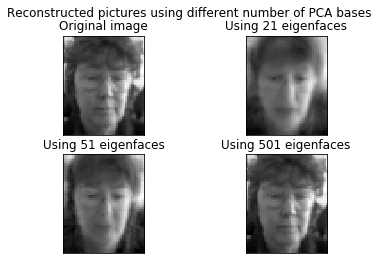

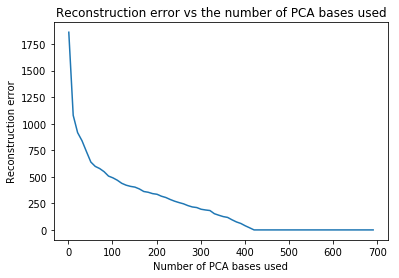

In [16]:
# Let's investigate the reconstruction error of a picture using different number of PCA bases
# The less bases we take, the worse the quality of the reconstructed picture will be, because we lose more and more information

# Print the original image
plt.subplot(221),plt.imshow(np.reshape(pca_train[0, :], (46,56)).T, cmap = 'gist_gray')
plt.suptitle('Reconstructed pictures using different number of PCA bases')
plt.title('Original image'), plt.xticks([]), plt.yticks([])
pltcount = 2
reconst_bases = np.arange(1, 700, 10)
reconst_errors = np.zeros(reconst_bases.shape)
k=0
for i in reconst_bases:
    
    # Take the i largest eigenvalues and their corresponding eigenvectors
    eigvecs_rec = eigvecs[:, :i]
    eigvals_rec = eigvals[:i]
    
    # Project the training image to the space spanned by these eigenvectors
    proj_pca_train_norm_rec = np.dot(pca_train_norm[0, :], eigvecs_rec)
    # Now in array proj_pca_train_norm_rec we have the projected coordinates for the face image
    
    # Reconstruct the face using the PCA bases
    face_reconst_rec = avg_face + np.dot(eigvecs_rec, proj_pca_train_norm_rec)
    
    # Calculate the reconstruction error and save it in an array
    reconst_errors[k] = np.linalg.norm(face_reconst_rec-pca_train[0, :])
    k = k+1
    
    if (i==21 or i==51 or i==501):
        print (reconst_errors[k-1])
        #plt.figure()
        #plt.title('Image when {0} PCA bases are used'.format(str(i)))
        #plt.imshow(np.reshape(face_reconst_rec, (46,56)).T, cmap = 'gist_gray') # Show reconstructed faces
        
        plt.subplot(2,2,pltcount),plt.imshow(np.reshape(face_reconst_rec, (46,56)).T, cmap = 'gist_gray')
        plt.title('Using {0} eigenfaces'.format(str(i))), plt.xticks([]), plt.yticks([])
        
        pltcount = pltcount+1
        print(pltcount)

plt.figure()
plt.plot(reconst_bases, reconst_errors)
plt.ylabel('Reconstruction error')
plt.xlabel('Number of PCA bases used')
plt.title('Reconstruction error vs the number of PCA bases used')

Testing

In [17]:
# Now that we've trained our model, let's test it on our testing data set
# First, let's normalise the testing set (subtract the average face from all face images)

pca_test_norm = pca_test-avg_face # Works because of broadcasting

# Then let's project each testing image to the eigenspace (space spanned by the best n eigenvectors)
proj_pca_test_norm = np.zeros((104, n))
for i in range(104):
    proj_pca_test_norm [i, :] = np.dot(pca_test_norm[i, :], eigvecs_best)

print (proj_pca_test_norm, proj_pca_test_norm.shape)

# Now in array proj_pca_test_norm, in each row, we have the projected coordinates for each face image

[[ -363.62483736   687.34808312   931.07781267 ...   -23.88518326
    148.34107921    15.55906027]
 [ 1312.02384663 -1083.32892105   -27.24819437 ...   -64.34153716
     48.50738492    -7.6052195 ]
 [ -735.89769071  1300.65307418 -1887.08919115 ...   -70.34872166
   -166.14211931    27.53286231]
 ...
 [  713.66728721   174.0786356   -221.39490549 ...   -34.54733048
     66.79614758   -85.95075792]
 [-1095.3109708   -585.8646707  -1402.78436232 ...   240.04448972
    -15.81445067    33.52583967]
 [  800.40020948   238.23681859  -437.37563005 ...    47.13722025
    128.09236561   145.09471483]] (104, 50)


1211.5283654103396 0
1
1


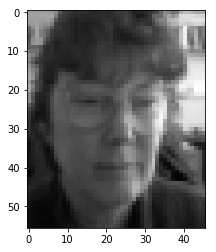

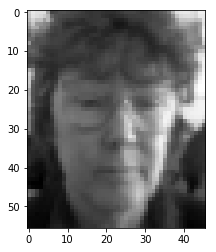

In [18]:
# Let's classify the first image

# Print our actual image
plt.imshow(np.reshape(pca_test[0, :], (46,56)).T, cmap = 'gist_gray')

# How far is the image from each of the testing points?
distance = np.zeros(416)
for i in range(416):
    distance[i] = np.linalg.norm(proj_pca_train_norm[i, :]-proj_pca_test_norm[0, :])
print (distance.min(), distance.argmin())

# Which identity does our picture belong to according to the learning set?
print (training[distance.argmin(), 2576])
# Which identity does it actually belong to?
print (test[0, 2576])

# Print the picture that our picture is the closest to
plt.figure()
plt.imshow(np.reshape(pca_train[distance.argmin(), :], (46,56)).T, cmap = 'gist_gray')

[ 1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12 12
 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24 24
 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36
 37 37 38 38 39 39 40 40 41 41 42 42 43 43 44 44 45 45 46 46 47 47 48 48
 49 49 50 50 51 51 52 52] (104,)
[ 1  1 13  5  3  3  4  4  5  5  6  6  7 10  4 32  9  9 10 10 16 29 12 12
 13 13 16 14 15 15  5  2 47 30 18  8 21 21 20 20 21 21 14 19 23 23 24  6
 25 11 26 26 31 27 28 28 11 21 30 47 40 31 32 32 33 47 40  8 35 35 28  9
 37 37 36 27 39 37 32 40 35 46 16 42 14 43 29 11 39 45 46 46 47 47 29 29
 27 49 50 45 52 52 34 52] (104,)
0.5480769230769231


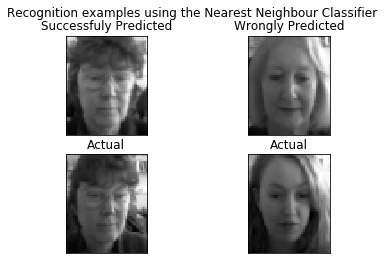

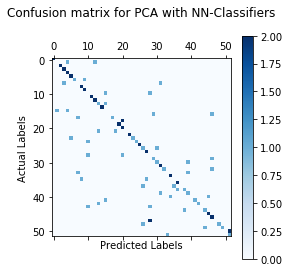

In [19]:
# Now let's do this for all of the testing images

distances = np.zeros((416, 104)) # In each row we store the distances from a particular training sample (1 column = 1 testing image's distances)

for k in range (104):
    for i in range(416):
        distances[i, k] = np.linalg.norm(proj_pca_train_norm[i, :]-proj_pca_test_norm[k, :])
        
# Now we have in each column the distances of the testing images from each of the training images.

# Next step is to find the minimum of each column, and the corresponding row index (per column)
smallest_distance = distances.min(axis=0) # min per columns
smallest_index = distances.argmin(axis=0) # min is at which index

# Put the actual test labels into a vector
actual_label = test [:, 2576].T
print (actual_label, actual_label.shape)

# Which identity does it belong to according to the learning set?
print (training[smallest_index, 2576], training[smallest_index, 2576].shape)

is_it_same = (training[smallest_index, 2576]==actual_label)
percentage_nn = np.sum(is_it_same)/104
print (percentage_nn)

# Show example success and failure cases (with both of the methods actually)

plt.subplot(221),plt.imshow(np.reshape(training[smallest_index[0], :2576].T, (46,56)).T, cmap = 'gist_gray')
plt.suptitle('Recognition examples using the Nearest Neighbour Classifier')
plt.title('Successfuly Predicted'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(np.reshape(test[0, :2576].T, (46,56)).T, cmap = 'gist_gray')
plt.title('Actual'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(np.reshape(training[smallest_index[3], :2576].T, (46,56)).T, cmap = 'gist_gray')
plt.title('Wrongly Predicted'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(np.reshape(test[3, :2576].T, (46,56)).T, cmap = 'gist_gray')
plt.title('Actual'), plt.xticks([]), plt.yticks([])

# Print the corresponding confusion matrix
cm_NN = confusion_matrix(actual_label, training[smallest_index, 2576])

plt.matshow(cm_NN, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion matrix for PCA with NN-Classifiers', y=1.2)
plt.show()

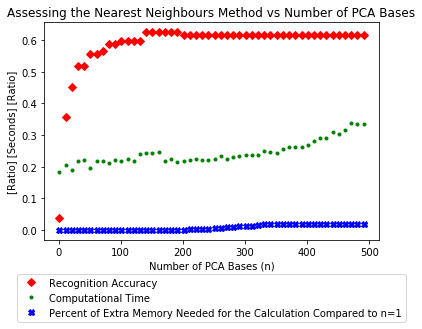

In [23]:
# Now let's vary the number of PCA bases
# We keep the largest n eigenvalues and their corresponding eigenvectors n<=415, the other eigenvalues are zero
nbases = np.arange(1, 500, 10)
time_per_base_nn = np.zeros(nbases.shape)
memory_per_base_nn = np.zeros(nbases.shape)
percentages = np.zeros (nbases.shape)
ol = 0
for n in nbases:
    gc.collect()
    time_a=time.time()
    eigvecs_best = eigvecs[:, :n]
    eigvals_best = eigvals[:n]
    
    # Projecting each training data point to the space spanned by the eigenvectors
    proj_pca_train_norm = np.zeros((416, n))
    for i in range(416):
        proj_pca_train_norm [i, :] = np.dot(pca_train_norm[i, :], eigvecs_best)
    # Now in array proj_pca_train_norm, in each row, we have the projected coordinates for each face image

    pca_test_norm = pca_test-avg_face # Works because of broadcasting

    # Then let's project each testing image to the eigenspace (space spanned by the best n eigenvectors)
    proj_pca_test_norm = np.zeros((104, n))
    for i in range(104):
        proj_pca_test_norm [i, :] = np.dot(pca_test_norm[i, :], eigvecs_best)
    # Now in array proj_pca_test_norm, in each row, we have the projected coordinates for each face image
    
    distances = np.zeros((416, 104)) # In each row we store the distances from a particular training sample (1 column = 1 testing image's distances)

    for k in range (104):
        for i in range(416):
            distances[i, k] = np.linalg.norm(proj_pca_train_norm[i, :]-proj_pca_test_norm[k, :])
    # Now we have in each column the distances of the testing images from each of the training images.

    # Next step is to find the minimum of each column, and the corresponding row index (per column)
    smallest_distance = distances.min(axis=0) # min per columns
    smallest_index = distances.argmin(axis=0) # min is at which index

    # Put the actual test labels into a vector
    actual_label = test [:, 2576].T
    
    is_it_same = (training[smallest_index, 2576]==actual_label)
    percentages[ol] = np.sum(is_it_same)/104
    
    time_b = time.time()
    time_per_base_nn[ol]=time_b-time_a
    process = psutil.Process(os.getpid())
    if (n==1):
        mem1 = process.memory_info().rss
    process = psutil.Process(os.getpid())
    memory_per_base_nn[ol] = (((process.memory_info().rss)/mem1-1))
    ol = ol+1

#plt.figure()
#plt.plot(nbases, percentages)
#plt.title('NN Recognition success rate vs the number of PCA bases used')


plt.figure()
plt.plot(nbases, percentages, 'rD', label = 'Recognition Accuracy')
plt.plot(nbases, time_per_base_nn, 'g.', label = 'Computational Time')
plt.plot(nbases, memory_per_base_nn, 'bX', label = 'Percent of Extra Memory Needed for the Calculation Compared to n=1')
plt.title('Assessing the Nearest Neighbours Method vs Number of PCA Bases')
plt.xlabel('Number of PCA Bases (n)')
plt.ylabel('[Ratio] [Seconds] [Ratio]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.4))
plt.show()

(8, 8) (8, 8)
(2576, 5) (8, 5)
698.109987013318
[ 1  1  2  5  3  3  4  4  5  5  6  6  7  7 16 16 13  9 10 10 16 28 12 12
 13 13 14 14 15 15  2  3 30 30 18 18 19 21 20 20 21 21 14 22 23 23 24 19
 25 25 26 26 27 27 28 28 26 29 30 47 31 31 32 40 33  1 34 13 35 35 36 16
 37 37 50 38 39 39  2 34 41 41 16 42 16 19 44 38 45 45 46 46 33 33 29 48
 49 49 50 50 51 51 52 52]
[ 1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12 12
 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24 24
 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33 34 34 35 35 36 36
 37 37 38 38 39 39 40 40 41 41 42 42 43 43 44 44 45 45 46 46 47 47 48 48
 49 49 50 50 51 51 52 52]
0.7211538461538461


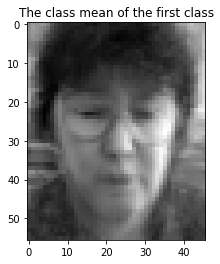

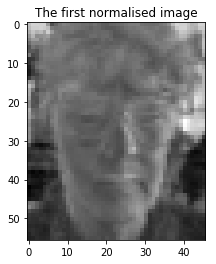

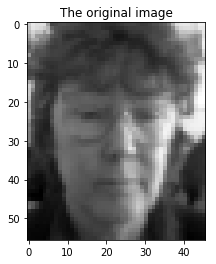

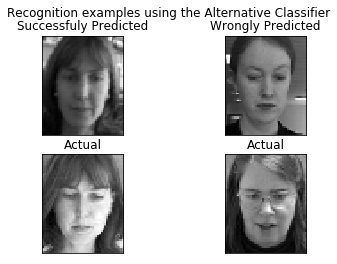

<Figure size 432x288 with 0 Axes>

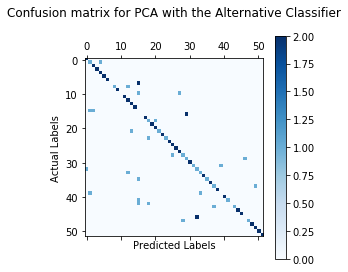

In [21]:
# Alternative method of face recognition: based on reconstruction errors per class

# Create a list of arrays, in each array put the training samples that belong to the same picture
class_sets = []
for i in range(52):
    class_sets.append(training[i==(training[:,-1]-1),:2576])
    
# Calculate the mean face of each class
class_means = np.zeros((52,2576))
for i in range(52):
    class_means[i,:] = np.mean(class_sets[i], axis=0)

# Show the mean image of one of the classes
plt.figure()
plt.imshow(np.reshape(class_means[0, :], (46,56)).T, cmap = 'gist_gray')
plt.title('The class mean of the first class')

# Now let's subtract the class mean image from the training face images in each of the classes
class_pca_train_norm = []
for i in range(52):
    class_pca_train_norm.append(class_sets[i]-class_means[i, :]) # Broadcasting

# Show the first normalised face image of the first class and notice that it is distorted
plt.figure()
plt.imshow(np.reshape(class_pca_train_norm[0][0, :], (46,56)).T, cmap = 'gist_gray') 
plt.title('The first normalised image')

# Computing the covariance matrix for each of the classes, using the low dimensional method
class_cov = []
for i in range(52):
    class_cov.append(np.dot(class_pca_train_norm[i], class_pca_train_norm[i].T)/(class_sets[i].shape[0]))
print (class_cov[0].shape, class_cov[51].shape)

# Computing the eigenvalues and eigenvectors of each per-class covariance matrix per class and measuring how long it takes

# measure how long it takes!!!

n = 5 # Needs to be less or equal to the sample size of the smallest class
class_projected = []
class_eigvecs = []
for i in range(52):
    number_of_samples = class_sets[i].shape[0]
    eigvals_tmp, eigvecs_tmp = np.linalg.eig(class_cov[i]) # These are not ordered, so we need to order them according to the eigenvalues
    
    # Taking the real part of the eigenvalues (complex eigenvalues are the result of calculation rounding errors, because the covariance matrices are symmetric)
    eigvals_tmp = np.real(eigvals_tmp)
    eigvecs_tmp = np.real(eigvecs_tmp)
    
    # Order eigenvalues and eigenvectors according to the size of the eigenvalues
    index_tmp = (abs(eigvals_tmp)).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector eigvals)
    eigvals_tmp = eigvals_tmp[index_tmp]
    eigvecs_tmp = eigvecs_tmp[:,index_tmp]

    eigvecs_best_tmp_tmp = np.dot(class_pca_train_norm[i].T, eigvecs_tmp)
    eigvecs_best_tmp_tmp = eigvecs_best_tmp_tmp/np.linalg.norm(eigvecs_best_tmp_tmp, axis=0)

    # We keep the largest n eigenvalues in each class and the corresponding eigenvectors
    # n has to be the same for all of the classes! Therefore n <= min(class_sample_size)
    eigvecs_best_tmp = eigvecs_best_tmp_tmp[:, :n]
    eigvals_best_tmp = eigvals_tmp[:n]
    
    # Projecting each training data point in each class to the space spanned by the per-class best n eigenvectors
    class_proj_pca_train_norm = np.zeros((number_of_samples, n))
    for j in range(number_of_samples):
        class_proj_pca_train_norm [j, :] = np.dot(class_pca_train_norm[i][j, :], eigvecs_best_tmp)
    class_projected.append(class_proj_pca_train_norm)
    class_eigvecs.append(eigvecs_best_tmp)
    
print (class_eigvecs[0].shape, class_projected[0].shape) # 2576 x sample size and sample size x n respectively
# Now in list of arrays class_projected, in each row of each array in the list, we have the projected coordinates for the faces in the corresponding class

# Let's reconstruct one picture to check if we've done everything correctly.
# Print the original image first
plt.figure()
plt.imshow(np.reshape(class_sets[0][0, :], (46,56)).T, cmap = 'gist_gray')
plt.title('The original image')

face_rec_alt = class_means[0, :] + np.dot(class_eigvecs[0], class_projected[0][0, :])
rec_err_alt = np.linalg.norm(class_sets[0][0,:]-face_rec_alt)

plt.figure()
plt.imshow(np.reshape(face_rec_alt, (46,56)).T, cmap = 'gist_gray')
plt.title('The reconstructed image')
print (rec_err_alt) # Print the reconstruction error

# Now subtract each class' mean from the testing pictures and project them to each class' best n eigenvectors
class_pca_test_norm = []
for i in range(52):
    class_pca_test_norm.append(pca_test-class_means[i, :]) # Works because of broadcasting

# Projecting each testing image to each of the class eigenspaces (space spanned by the best n eigenvectors for the class)
class_proj_test = []
for i in range(52):
    proj_pca_test_norm_alt = np.zeros((104, n))
    for l in range (104):
        proj_pca_test_norm_alt[l, :] = np.dot(class_pca_test_norm[i][l, :], class_eigvecs[i])
    class_proj_test.append(proj_pca_test_norm_alt)

# Reconstruct each testing picture in each of the classes
reconstruction_errors = np.zeros((52, 104)) # 1 column = 1 testing image's reconstruction error in each of the classes
for z in range(104):
    for i in range(52):
        face_reconstructed = class_means[i, :] + np.dot(class_eigvecs[i], class_proj_test[i][z, :])
        reconstruction_errors[i, z] = np.linalg.norm (pca_test[z, :]-face_reconstructed)
print (np.argmin(reconstruction_errors, axis = 0)+1)
print (actual_label)

is_it_same_alt = ((np.argmin(reconstruction_errors, axis = 0)+1)==actual_label)
percentage_alt = np.sum(is_it_same_alt)/104
print (percentage_alt)

plt.subplot(221),plt.imshow(np.reshape(class_sets[2][0, :2576].T, (46,56)).T, cmap = 'gist_gray')
plt.suptitle('Recognition examples using the Alternative Classifier')
plt.title('Successfuly Predicted'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(np.reshape(test[4, :2576].T, (46,56)).T, cmap = 'gist_gray')
plt.title('Actual'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(np.reshape(class_sets[1][0, :2576].T, (46,56)).T, cmap = 'gist_gray')
plt.title('Wrongly Predicted'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(np.reshape(test[30, :2576].T, (46,56)).T, cmap = 'gist_gray')
plt.title('Actual'), plt.xticks([]), plt.yticks([])


# Print the corresponding confusion matrix
cm_alt = confusion_matrix(actual_label, np.argmin(reconstruction_errors, axis = 0)+1)
plt.figure()
plt.matshow(cm_alt, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion matrix for PCA with the Alternative Classifier', y=1.2)
plt.show()

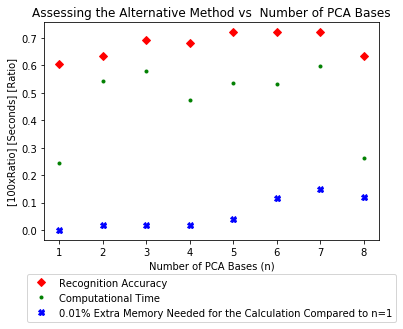

In [22]:
# Let's vary the number of PCA bases

# Alternative method of face recognition: based on reconstruction errors per class

# Create a list of arrays, in each array put the training samples that belong to the same picture
class_sets = []
for i in range(52):
    class_sets.append(training[i==(training[:,-1]-1),:2576])
    
# Calculate the mean face of each class
class_means = np.zeros((52,2576))
for i in range(52):
    class_means[i,:] = np.mean(class_sets[i], axis=0)

# Now let's subtract the class mean image from the training face images in each of the classes
class_pca_train_norm = []
for i in range(52):
    class_pca_train_norm.append(class_sets[i]-class_means[i, :]) # Broadcasting

# Computing the covariance matrix for each of the classes, using the low dimensional method
class_cov = []
for i in range(52):
    class_cov.append(np.dot(class_pca_train_norm[i], class_pca_train_norm[i].T)/(class_sets[i].shape[0]))

# Computing the eigenvalues and eigenvectors of each per-class covariance matrix per class and measuring how long it takes

pca_test_bases = np.arange(1, 9, 1) # Needs to be less or equal to the sample size of the smallest class
success_rates_per_base = np.zeros(pca_test_bases.shape)
time_per_base = np.zeros(pca_test_bases.shape)
memory_per_base = np.zeros(pca_test_bases.shape)
for n in pca_test_bases:
    time_a=time.time()
    class_projected = []
    class_eigvecs = []
    for i in range(52):
        number_of_samples = class_sets[i].shape[0]
        eigvals_tmp, eigvecs_tmp = np.linalg.eig(class_cov[i]) # These are not ordered, so we need to order them according to the eigenvalues
    
        # Taking the real part of the eigenvalues (complex eigenvalues are the result of calculation rounding errors, because the covariance matrices are symmetric)
        eigvals_tmp = np.real(eigvals_tmp)
        eigvecs_tmp = np.real(eigvecs_tmp)
    
        # Order eigenvalues and eigenvectors according to the size of the eigenvalues
        index_tmp = (abs(eigvals_tmp)).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector eigvals)
        eigvals_tmp = eigvals_tmp[index_tmp]
        eigvecs_tmp = eigvecs_tmp[:,index_tmp]

        eigvecs_best_tmp_tmp = np.dot(class_pca_train_norm[i].T, eigvecs_tmp)
        eigvecs_best_tmp_tmp = eigvecs_best_tmp_tmp/np.linalg.norm(eigvecs_best_tmp_tmp, axis=0)

        # We keep the largest n eigenvalues in each class and the corresponding eigenvectors
        # n has to be the same for all of the classes! Therefore n <= min(class_sample_size)
        eigvecs_best_tmp = eigvecs_best_tmp_tmp[:, :n]
        eigvals_best_tmp = eigvals_tmp[:n]
    
        # Projecting each training data point in each class to the space spanned by the per-class best n eigenvectors
        class_proj_pca_train_norm = np.zeros((number_of_samples, n))
        for j in range(number_of_samples):
            class_proj_pca_train_norm [j, :] = np.dot(class_pca_train_norm[i][j, :], eigvecs_best_tmp)
        class_projected.append(class_proj_pca_train_norm)
        class_eigvecs.append(eigvecs_best_tmp)
        # Now in list of arrays class_projected, in each row of each array in the list, we have the projected coordinates for the faces in the corresponding class

    face_rec_alt = class_means[0, :] + np.dot(class_eigvecs[0], class_projected[0][0, :])
    rec_err_alt = np.linalg.norm(class_sets[0][0,:]-face_rec_alt)

    # Now subtract each class' mean from the testing pictures and project them to each class' best n eigenvectors
    class_pca_test_norm = []
    for i in range(52):
        class_pca_test_norm.append(pca_test-class_means[i, :]) # Works because of broadcasting

    # Projecting each testing image to each of the class eigenspaces (space spanned by the best n eigenvectors for the class)
    class_proj_test = []
    for i in range(52):
        proj_pca_test_norm_alt = np.zeros((104, n))
        for l in range (104):
            proj_pca_test_norm_alt[l, :] = np.dot(class_pca_test_norm[i][l, :], class_eigvecs[i])
        class_proj_test.append(proj_pca_test_norm_alt)

    # Reconstruct each testing picture in each of the classes
    reconstruction_errors = np.zeros((52, 104)) # 1 column = 1 testing image's reconstruction error in each of the classes
    for z in range(104):
        for i in range(52):
            face_reconstructed = class_means[i, :] + np.dot(class_eigvecs[i], class_proj_test[i][z, :])
            reconstruction_errors[i, z] = np.linalg.norm (pca_test[z, :]-face_reconstructed)

    is_it_same_alt = ((np.argmin(reconstruction_errors, axis = 0)+1)==actual_label)
    success_rates_per_base[n-1] = np.sum(is_it_same_alt)/104
    time_b = time.time()
    time_per_base[n-1]=time_b-time_a
    process = psutil.Process(os.getpid())
    if (n==1):
        mem1 = process.memory_info().rss
    process = psutil.Process(os.getpid())
    memory_per_base[n-1] = 100*((process.memory_info().rss)/mem1-1)

plt.figure()
plt.plot(pca_test_bases, success_rates_per_base, 'rD', label = 'Recognition Accuracy')
plt.plot(pca_test_bases, time_per_base, 'g.', label = 'Computational Time')
plt.plot(pca_test_bases, memory_per_base, 'bX', label = '0.01% Extra Memory Needed for the Calculation Compared to n=1')
plt.title('Assessing the Alternative Method vs  Number of PCA Bases')
plt.xlabel('Number of PCA Bases (n)')
plt.ylabel('[100xRatio] [Seconds] [Ratio]')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.4))
plt.show()